This notebook is used to demonstrate how to probe the relationship between geophysical properties using spatial queries and interpolation. Some parts of this notebook are rather messy as a result of
needing to use data from two different AEM inversions

Neil Symington

neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
import netCDF4
import pandas as pd
import shapely
import os
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy as db
from sqlite3 import dbapi2 as sqlite
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
from hydrogeol_utils import SNMR_utils, spatial_functions, AEM_utils
from sqlalchemy import create_engine, event

In [3]:
##TODO replace with hydrogeol_utils function
def resample_categorical_intervals(df, parameter_columns,
                                   interval_columns, new_intervals):
    # If the parameter input is a string and not a list make it a list
    if isinstance(parameter_columns, ("".__class__, u"".__class__)):
        parameter_columns = [parameter_columns]
    
    # Create a dataframe to add to
    df_resampled = pd.DataFrame(columns = interval_columns, data = new_intervals)
    
    for p in parameter_columns:
        
        df_resampled[p] = ''
        
        # Iterate through the new intervals
        for i, interval in enumerate(new_intervals):
            
            new_depth_from = interval[0]
            new_depth_to = interval[1]

            mask = (df[interval_columns[0]] < new_depth_to) & (df[interval_columns[1]] > new_depth_from)
            
            v = df[mask][p].mode()
            
            if len(v) == 1:
                
                df_resampled.at[i, p] = v.values[0]
            
            elif len(v) > 1:

                df_resampled.at[i, p] = 'transition'
    
    return df_resampled

In [4]:
# First we will import the AEM conductivity point line data
# The AEM data is in a netCDF file created from a asci files using geophys_utils
# https://github.com/GeoscienceAustralia/geophys_utils


# Load East Kimberley data
infile  = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\EK_nbc_inversions\OrdKeep_borehole_constrained\netcdf\OrdKeep2019_ModeExp_cor2DLogOrd.nc"
ek_cond = netCDF4.Dataset(infile)

# Create an instance of point utils

cond_point_util = NetCDFPointUtils(ek_cond)

wkt, aem_coords = cond_point_util.utm_coords(cond_point_util.xycoords)

In [5]:
# List the variables for the Ord Bonaparte AEM data
print(ek_cond)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    geospatial_east_min: 413602.8
    geospatial_east_max: 565524.1
    geospatial_east_units: m
    geospatial_north_min: 8244470.0
    geospatial_north_max: 8360774.0
    geospatial_north_units: m
    title: Dataset read from ASEG-GDF file OrdKeep2019_ModeExp_cor2DLogOrd.dat
    Conventions: CF-1.6,ACDD-1.3
    featureType: trajectory
    geospatial_vertical_min: -28.13
    geospatial_vertical_max: 158.25
    geospatial_vertical_units: m
    geospatial_vertical_resolution: point
    geospatial_vertical_positive: up
    history: Converted from ASEG-GDF file ..\combined_aseg_gdf\OrdKeep2019_ModeExp_cor2DLogOrd.dat using definitions file ..\combined_aseg_gdf\OrdKeep2019_ModeExp_cor2DLogOrd.dfn
    date_created: 2019-03-15T10:18:54.981470
    geospatial_east_resolution: point
    geospatial_north_resolution: point
    geospatial_bounds: POLYGON((128.7680 -15.8787, 128.7679 -15.8787, 128.7677 -15.8787, 1

In [6]:
# Bring in the SNMR inversions from a spreadsheet with some preprocessing done on it

infile = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\aquifer_properties\data\EK_SNMR_labelled.csv'
df_SNMR_inversions = pd.read_csv(infile)


In [7]:
# Our next tak is to bring the header SNMR data in 

# Connect to the SNMR database

DB_PATH = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\NMR\SNMR\East_Kimberley_SNMR.sqlite"


SPATIALITE_PATH = r'C:\mod_spatialite-4.3.0a-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = engine.connect()

st_acqus = ','.join([str(x) for x in list(df_SNMR_inversions['acquisition_id'].unique())])

query = """



SELECT
              s.site_id,
              s.Field_ID,
              s.mid_X,
              s.mid_Y,
              a.acquisition_id,
              s.geometry,
              a.pulse_sequence,
              a.pulse_length,
              imm.Depth_of_Investigation
              
FROM 

             sites as s
             JOIN acquisitions as a on s.site_id=a.site_id
             JOIN inverse_model_metadata as imm on a.acquisition_id = imm.acquisition_id

WHERE

            a.acquisition_id in ({});""".format(st_acqus)

df_acquisitions = pd.read_sql_query(query, connection, index_col = 'acquisition_id')

# Since we are interested in the shallow resolution we will use the shorter pulse SNMR


df_acquisitions = df_acquisitions.loc[SNMR_utils.choose_snmr_site_acquisition(df_acquisitions,
                                 pulse_sequence_criteria = ['FID'],
                                 pulse_length_criteria="max")]

In [8]:
# Find the nearest neighbours for the 

distances, indices = spatial_functions.nearest_neighbours(df_acquisitions[['mid_X', 'mid_Y']],
                                                         aem_coords, points_required = 10, 
                                                          max_distance = 250.)


In [9]:
# The next step is to iterate through the sites, choose which survey to extract
# our points from based on the smallest distance, use an inverse distance 
# weighting scheme to calculate weights and use this to estimate a representative
# conductivity profile for each site

# We will save the profiles in a pandas dataframe with a SNMR site key column

df_conductivity = pd.DataFrame(columns = {'acquisition_id',
                                          'Depth_from',
                                          'Depth_to',
                                          'conductivity'})

# Iteratively extract the conductivity profiles

for i, (index, row) in enumerate(df_acquisitions.iterrows()):
    
    # This is a check against null which are returned if the nearest neighbour is further
    # than the maximum distance
    if not np.isnan(distances[i]).all():
        
        df_conductivity_profile = AEM_utils.extract_conductivity_profile(ek_cond,
                                                       distances[i],
                                                       indices[i],
                                                       as_dataframe = True)
        # Add the SNMR id to the column
        df_conductivity_profile['acquisition_id'] = index
    
        # Append the site profile to the dataframe
        df_conductivity = df_conductivity.append(df_conductivity_profile, sort = True)
    
df_conductivity.reset_index(inplace=True, drop=True)

In [29]:
# Iterate through the acquisitions and interpolate the SNMR intervals onto the AEM intervals
# using an average

# Define the columns that are being interpolated 
interpolated_columns = ['Mobile_water_content', 'Bound_water_content', 
                     'Total_water_content', 'K']

interval_columns = ['Depth_from','Depth_to']

for item in interpolated_columns:
    df_conductivity[item] = np.nan

df_conductivity['label'] = ''

# Iterate through inversions and interpolate them onto a new set of intervals     
for idx in df_acquisitions.index:
    # Define the new intervals based on the conductivity intervals
    mask  = df_conductivity['acquisition_id']==idx
    
    new_intervals = df_conductivity[mask][['Depth_from', 'Depth_to']]
    
    # Extract the inversion data for the site
    mask = df_SNMR_inversions['acquisition_id']==idx
    
    df_inv = df_SNMR_inversions[mask]
    
    # Interpolate and add the interpolated parameter columns to the dataframe
    
    interpolated_SNMR = spatial_functions.interpolate_layered_model(df_inv,
                                                                   interpolated_columns,
                                                                   interval_columns,
                                                                   new_intervals)[interpolated_columns]
    # Now we also want to interpolate the labels
    interpolated_SNMR['label'] = spatial_functions.resample_categorical_intervals(df_inv,
                                                                   ['label'],
                                                                   interval_columns,
                                                                   new_intervals.values)['label'].values
    
    df_conductivity.at[new_intervals.index,
                       interpolated_columns + ['label']] = interpolated_SNMR[interpolated_columns + ['label']]


In [49]:
# Remove columns with zeros for mobile or bound water

mask = (df_conductivity['K'] != 0)

df_conductivity_SNMR = df_conductivity[mask]


In [51]:
# Create colour values

# Do some histrograms

colours = df_conductivity_SNMR['label'].values.copy()


colours[colours == 'unsaturated'] = 'white'

colours[colours == 'Cenozoic'] = 'blue'

colours[colours == 'Permocarb'] = 'green'

colours[colours == 'Milligans'] = 'red'

colours[colours == 'transition'] = 'grey'



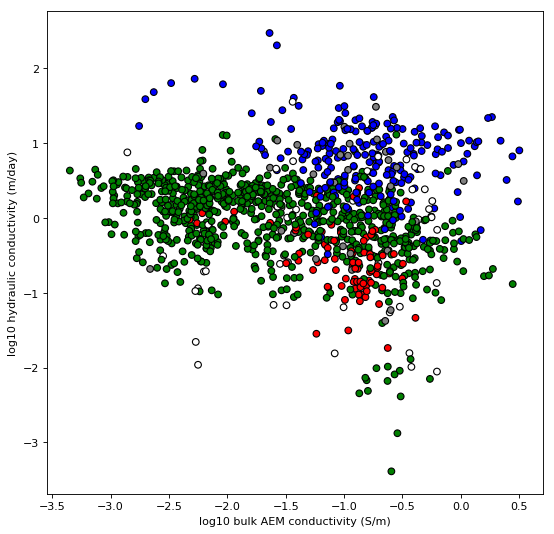

In [54]:
# Focussing on the mobile water content we will plot the results

# Note that this plot includes the unsaturated zone

plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(np.log10(df_conductivity_SNMR['conductivity'].values),
           (np.log10(df_conductivity_SNMR['K'].values)), 
           c =colours, edgecolors = 'k')
plt.xlabel('log10 bulk AEM conductivity (S/m)')
plt.ylabel('log10 hydraulic conductivity (m/day)')
plt.show()

In [ ]:
# Lets be specific now

